# T2B5

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [2]:
sedan_1 = pd.read_excel('light-duty-emissions-time-series-data_v2.xlsx', '000001111')
sedan_1 = sedan_1.dropna()
# Integrate total NOx emission over time
sedan_1['NOx_cum'] = sedan_1.NOx_raw.cumsum()

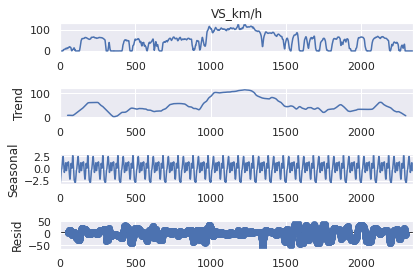

<Figure size 720x720 with 0 Axes>

In [28]:
result = seasonal_decompose(sedan_1['VS_km/h'], model='additive',period=100)
result.plot()
plt.figure(figsize=(10,10))

plt.show()

In [4]:
sedan_1.describe()

,Time_s,VS_km/h,Lam,Texh_C,NOx_ppm,VA,NOx_raw,NOx_cum
count,2349.000000,2349.000000,2349.000000,2349.000000,2349.000000,2349.000000,2.349000e+03,2349.000000
mean,1175.000000,47.879300,1.086266,45.626380,31.000337,0.000000,1.445796e-04,0.225069
std,678.242213,34.870613,0.343688,13.596679,40.120232,2.326872,7.210585e-04,0.104933
min,1.000000,0.000000,0.954440,21.505555,-0.942670,-10.658827,-1.308037e-03,0.000031
25%,588.000000,14.271251,0.998989,36.190001,9.422332,-0.668970,9.129459e-07,0.110501
50%,1175.000000,51.855509,1.000975,43.427776,19.310762,0.000000,5.161862e-06,0.233136
75%,1762.000000,65.477352,1.012438,55.380001,38.295496,0.843221,3.945043e-05,0.331237
max,2349.000000,127.914941,4.956205,101.389999,511.933777,9.313994,9.891555e-03,0.339618


In [5]:
col_name = ['Vehicle Speed', 'Lambda (Specific Air-Fuel ratio)', 'Exhaust Gas Temperature', 'NOx concentration',\
           'Vehicle Acceleration', 'NOx mass flow rate','Total grams of pollutant']

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

    
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

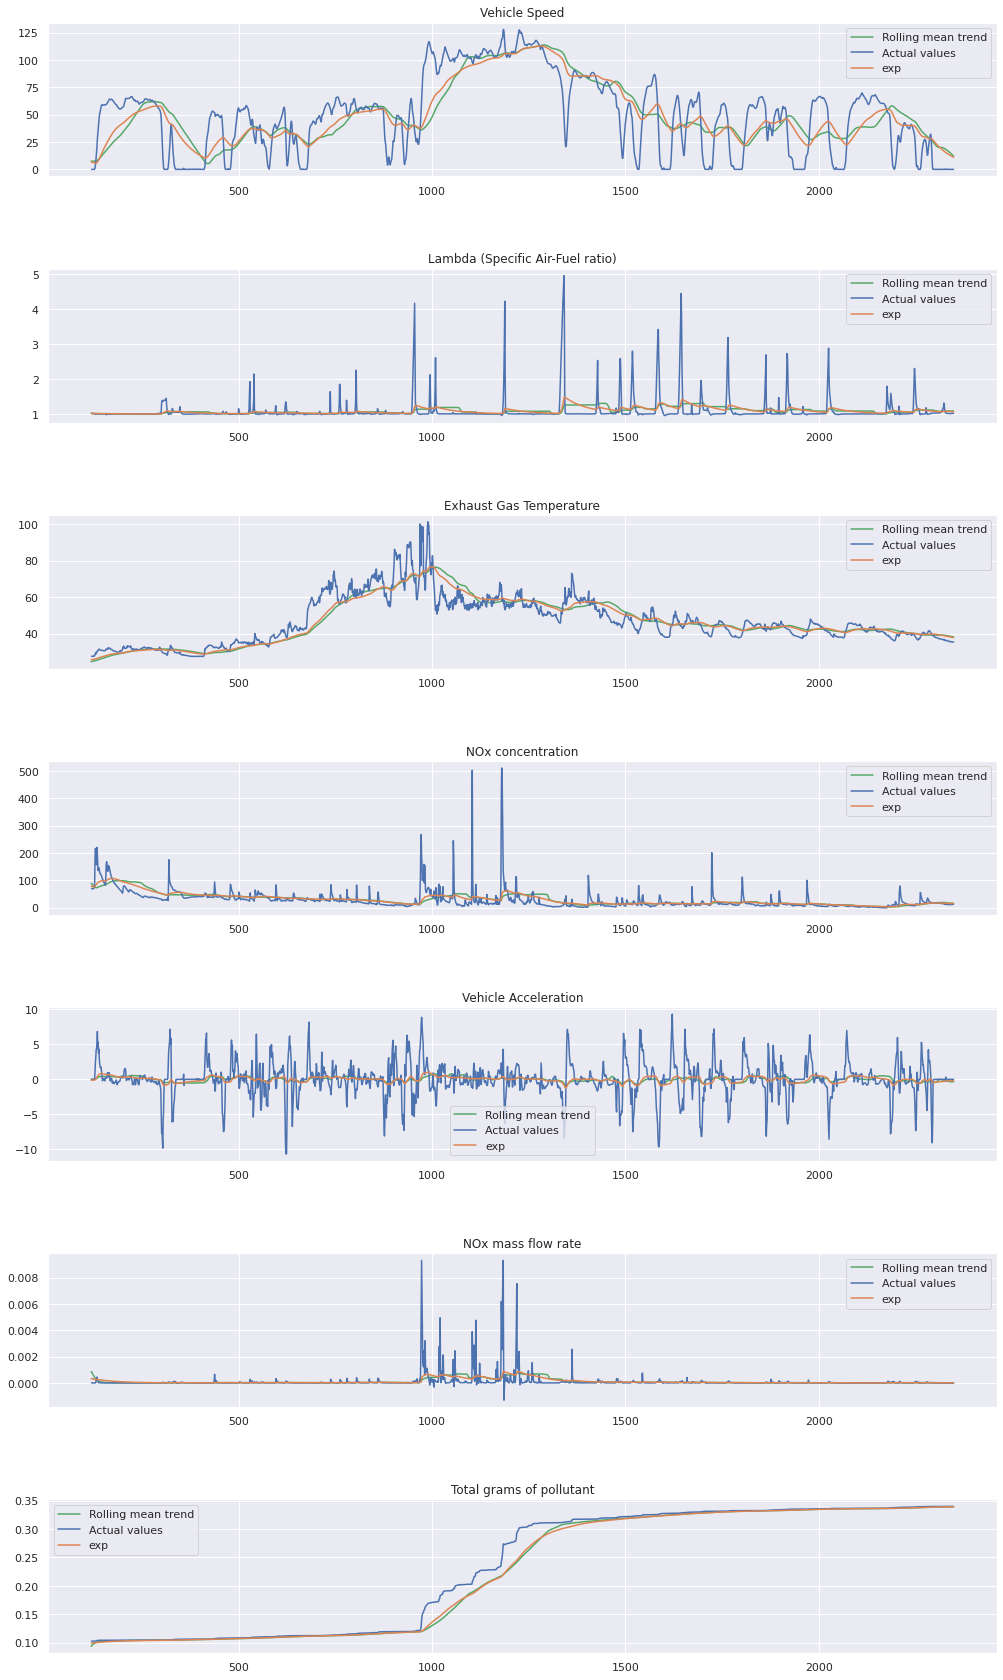

In [7]:
fig, axes = plt.subplots(7,1,figsize=(17,30))
window=120
for i in range(7):
    rolling_mean = sedan_1.iloc[:,i+1].rolling(window=window).mean()
    ewma = sedan_1.iloc[:,i+1].ewm(span=window,min_periods=window).mean()
#     axes[i].set_title(f'Moving average for {col_name[i]}\n window size = {window}')
    axes[i].plot(rolling_mean, 'g', label='Rolling mean trend')
    axes[i].plot(sedan_1.iloc[:,i+1][window:], label='Actual values')
    axes[i].plot(ewma,label='exp')
#     axes[i] = plot_moving_average(sedan_1.iloc[:,i+1],100)
    axes[i].set_title(col_name[i])
    axes[i].legend()
plt.subplots_adjust(hspace=0.6)

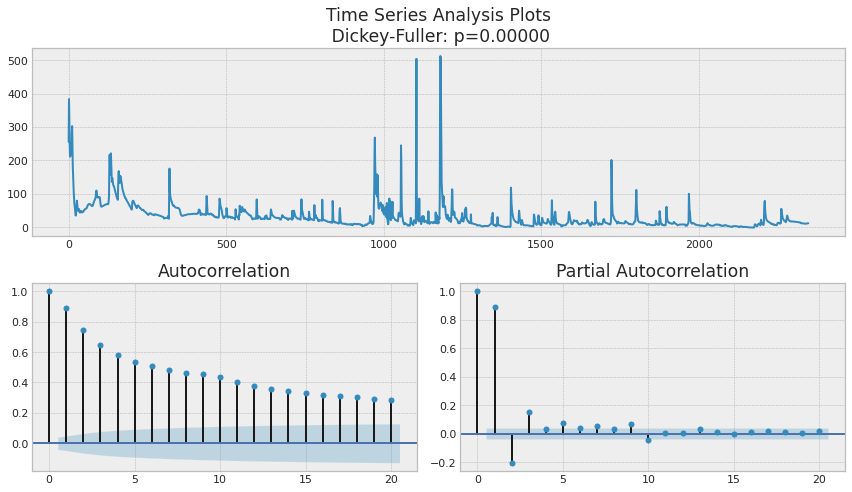

In [10]:
# Analysis plot for NOx concentration
tsplot(sedan_1.iloc[:,4],20)

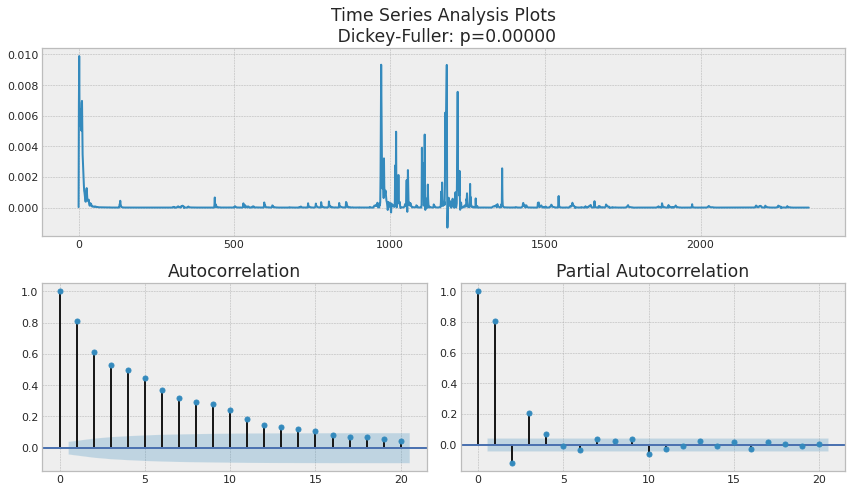

In [11]:
 # Analysis plot for NOx flow rate
tsplot(sedan_1.iloc[:,6],20)

## Grid search for ARIMA model

In [8]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

p_values = range(0,10)
d_values = range(0,10)
q_values = range(0,10)
warnings.filterwarnings("ignore")
evaluate_models(sedan_1.iloc[:,4].values, p_values, d_values, q_values)

(0, 0, 0)
ARIMA(0, 0, 0) MSE=715.743
(0, 0, 1)
ARIMA(0, 0, 1) MSE=257.553
(0, 0, 2)
ARIMA(0, 0, 2) MSE=161.108
(0, 0, 3)
ARIMA(0, 0, 3) MSE=127.226
(0, 0, 4)
ARIMA(0, 0, 4) MSE=113.263
(0, 0, 5)
ARIMA(0, 0, 5) MSE=104.815
(0, 0, 6)
ARIMA(0, 0, 6) MSE=100.606
(0, 0, 7)
ARIMA(0, 0, 7) MSE=96.639
(0, 0, 8)


# LSTM

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [23]:
X = sedan_1.drop(columns=['NOx_ppm']).values
y=sedan_1.iloc[:,4].values

In [28]:
X = X.reshape(len(X),1,-1)
print(X.shape,y.shape)

(2349, 1, 7) (2349,)


In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [67]:
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [122]:
sedan_1.iloc[:15]

,Time_s,VS_km/h,Lam,Texh_C,NOx_ppm,VA,NOx_raw,NOx_cum
0,1.0,0.000000,1.253660,21.810000,255.941618,0.000000,0.000031,0.000031
1,2.0,0.000000,1.177264,21.750000,383.448691,0.000000,0.006676,0.006707
2,3.0,0.000000,1.074155,21.549999,331.868438,0.000000,0.009892,0.016599
3,4.0,0.000000,1.027813,21.505555,257.317183,0.000000,0.006569,0.023168
4,5.0,0.008945,1.017377,21.549999,213.250542,0.008945,0.005361,0.028529
5,6.0,0.001174,1.029223,21.569999,210.905372,-0.007771,0.005653,0.034182
6,7.0,0.000000,1.043862,21.672222,235.080831,-0.001174,0.006413,0.040594
7,8.0,0.000000,1.066122,21.683333,233.395853,0.000000,0.005932,0.046526
8,9.0,0.000000,1.124822,21.640000,230.642865,0.000000,0.005325,0.051852
9,10.0,0.000000,1.124736,21.640000,218.090891,0.000000,0.005024,0.056876


In [131]:
y[11:30]

array([302.50848999, 244.84997868, 182.33801532, 154.88565076,
       133.0260871 , 105.77292603,  84.41456849,  70.05249179,
        64.39464474,  53.46276968,  42.05930878,  35.3848513 ,
        35.12196399,  46.84253186,  65.11445547,  79.64932007,
        70.89818918,  59.36734264,  52.4893623 ])

In [130]:
t_y[:20]

array([302.50848999, 244.84997868, 182.33801532, 154.88565076,
       133.0260871 , 105.77292603,  84.41456849,  70.05249179,
        64.39464474,  53.46276968,  42.05930878,  35.3848513 ,
        35.12196399,  46.84253186,  65.11445547,  79.64932007,
        70.89818918,  59.36734264,  52.4893623 ,  50.6171369 ])

In [59]:
t_x,t_y=temporalize(X,y,10)

In [68]:
scaler = StandardScaler().fit(flatten(t_x))
t_x_sacled = scale(t_x, scaler)

In [70]:
np.shape(t_x_sacled)

(2338, 10, 7)

Epoch 1/500
74/74 - 1s - loss: 29.7414
Epoch 2/500
74/74 - 1s - loss: 28.6249
Epoch 3/500
74/74 - 1s - loss: 25.5340
Epoch 4/500
74/74 - 1s - loss: 23.3460
Epoch 5/500
74/74 - 1s - loss: 22.4947
Epoch 6/500
74/74 - 1s - loss: 21.9978
Epoch 7/500
74/74 - 1s - loss: 21.6464
Epoch 8/500
74/74 - 1s - loss: 21.4078
Epoch 9/500
74/74 - 1s - loss: 21.2502
Epoch 10/500
74/74 - 1s - loss: 21.1353
Epoch 11/500
74/74 - 1s - loss: 21.0325
Epoch 12/500
74/74 - 1s - loss: 20.9344
Epoch 13/500
74/74 - 1s - loss: 20.8342
Epoch 14/500
74/74 - 1s - loss: 20.7159
Epoch 15/500
74/74 - 1s - loss: 20.5480
Epoch 16/500
74/74 - 1s - loss: 20.2632
Epoch 17/500
74/74 - 1s - loss: 19.9924
Epoch 18/500
74/74 - 1s - loss: 19.7093
Epoch 19/500
74/74 - 1s - loss: 19.4933
Epoch 20/500
74/74 - 1s - loss: 19.2005
Epoch 21/500
74/74 - 1s - loss: 18.9394
Epoch 22/500
74/74 - 1s - loss: 18.6657
Epoch 23/500
74/74 - 1s - loss: 18.4208
Epoch 24/500
74/74 - 1s - loss: 18.1103
Epoch 25/500
74/74 - 1s - loss: 17.8909
Epoch 26/

Epoch 204/500
74/74 - 1s - loss: 10.0387
Epoch 205/500
74/74 - 1s - loss: 10.0599
Epoch 206/500
74/74 - 1s - loss: 9.6738
Epoch 207/500
74/74 - 1s - loss: 9.6617
Epoch 208/500
74/74 - 1s - loss: 9.7375
Epoch 209/500
74/74 - 1s - loss: 9.5792
Epoch 210/500
74/74 - 1s - loss: 9.7510
Epoch 211/500
74/74 - 1s - loss: 9.8696
Epoch 212/500
74/74 - 1s - loss: 9.7556
Epoch 213/500
74/74 - 1s - loss: 9.9448
Epoch 214/500
74/74 - 1s - loss: 9.6118
Epoch 215/500
74/74 - 1s - loss: 9.8297
Epoch 216/500
74/74 - 1s - loss: 9.5520
Epoch 217/500
74/74 - 1s - loss: 9.7594
Epoch 218/500
74/74 - 1s - loss: 9.4189
Epoch 219/500
74/74 - 1s - loss: 9.3573
Epoch 220/500
74/74 - 1s - loss: 9.5808
Epoch 221/500
74/74 - 1s - loss: 9.7736
Epoch 222/500
74/74 - 1s - loss: 10.0416
Epoch 223/500
74/74 - 1s - loss: 9.4994
Epoch 224/500
74/74 - 1s - loss: 9.7333
Epoch 225/500
74/74 - 1s - loss: 9.4289
Epoch 226/500
74/74 - 1s - loss: 9.5117
Epoch 227/500
74/74 - 1s - loss: 9.7650
Epoch 228/500
74/74 - 1s - loss: 9.79

Epoch 409/500
74/74 - 1s - loss: 8.7731
Epoch 410/500
74/74 - 1s - loss: 8.7660
Epoch 411/500
74/74 - 1s - loss: 9.0287
Epoch 412/500
74/74 - 0s - loss: 8.3837
Epoch 413/500
74/74 - 1s - loss: 9.0013
Epoch 414/500
74/74 - 1s - loss: 8.3042
Epoch 415/500
74/74 - 1s - loss: 8.6756
Epoch 416/500
74/74 - 1s - loss: 8.6095
Epoch 417/500
74/74 - 1s - loss: 9.0123
Epoch 418/500
74/74 - 1s - loss: 8.2951
Epoch 419/500
74/74 - 1s - loss: 8.2546
Epoch 420/500
74/74 - 1s - loss: 8.4505
Epoch 421/500
74/74 - 1s - loss: 8.7586
Epoch 422/500
74/74 - 1s - loss: 8.8689
Epoch 423/500
74/74 - 1s - loss: 8.7252
Epoch 424/500
74/74 - 1s - loss: 9.0617
Epoch 425/500
74/74 - 1s - loss: 8.1079
Epoch 426/500
74/74 - 1s - loss: 8.6736
Epoch 427/500
74/74 - 1s - loss: 8.7833
Epoch 428/500
74/74 - 1s - loss: 8.7059
Epoch 429/500
74/74 - 1s - loss: 8.4515
Epoch 430/500
74/74 - 1s - loss: 8.8202
Epoch 431/500
74/74 - 1s - loss: 8.1067
Epoch 432/500
74/74 - 1s - loss: 8.2106
Epoch 433/500
74/74 - 1s - loss: 8.0781


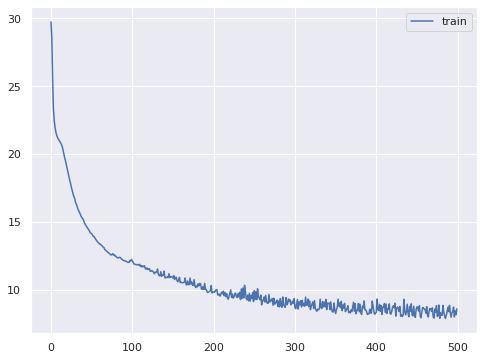

In [71]:
model = Sequential()
model.add(LSTM(20, input_shape=(t_x_sacled.shape[1], t_x_sacled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(t_x_sacled, t_y, epochs=500, batch_size=32, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Epoch 1/500
74/74 - 1s - loss: 29.1348
Epoch 2/500
74/74 - 1s - loss: 22.6820
Epoch 3/500
74/74 - 1s - loss: 20.0709
Epoch 4/500
74/74 - 1s - loss: 16.5817
Epoch 5/500
74/74 - 1s - loss: 14.6025
Epoch 6/500
74/74 - 1s - loss: 14.3463
Epoch 7/500
74/74 - 1s - loss: 14.0259
Epoch 8/500
74/74 - 1s - loss: 13.8481
Epoch 9/500
74/74 - 1s - loss: 13.6638
Epoch 10/500
74/74 - 1s - loss: 13.6121
Epoch 11/500
74/74 - 1s - loss: 13.4434
Epoch 12/500
74/74 - 1s - loss: 13.3575
Epoch 13/500
74/74 - 1s - loss: 13.1735
Epoch 14/500
74/74 - 1s - loss: 13.2801
Epoch 15/500
74/74 - 1s - loss: 12.9859
Epoch 16/500
74/74 - 1s - loss: 13.0058
Epoch 17/500
74/74 - 1s - loss: 12.8939
Epoch 18/500
74/74 - 1s - loss: 12.8495
Epoch 19/500
74/74 - 1s - loss: 13.0156
Epoch 20/500
74/74 - 1s - loss: 12.5393
Epoch 21/500
74/74 - 1s - loss: 12.9355
Epoch 22/500
74/74 - 1s - loss: 12.9061
Epoch 23/500
74/74 - 1s - loss: 12.5455
Epoch 24/500
74/74 - 1s - loss: 12.5020
Epoch 25/500
74/74 - 1s - loss: 12.6165
Epoch 26/

74/74 - 1s - loss: 8.8659
Epoch 207/500
74/74 - 1s - loss: 8.6804
Epoch 208/500
74/74 - 1s - loss: 8.8656
Epoch 209/500
74/74 - 1s - loss: 8.6603
Epoch 210/500
74/74 - 1s - loss: 8.1713
Epoch 211/500
74/74 - 1s - loss: 8.3940
Epoch 212/500
74/74 - 1s - loss: 9.7685
Epoch 213/500
74/74 - 1s - loss: 7.9347
Epoch 214/500
74/74 - 1s - loss: 8.4518
Epoch 215/500
74/74 - 1s - loss: 7.4781
Epoch 216/500
74/74 - 1s - loss: 7.4663
Epoch 217/500
74/74 - 1s - loss: 7.5654
Epoch 218/500
74/74 - 1s - loss: 8.0636
Epoch 219/500
74/74 - 1s - loss: 7.7951
Epoch 220/500
74/74 - 1s - loss: 7.5899
Epoch 221/500
74/74 - 1s - loss: 7.4794
Epoch 222/500
74/74 - 1s - loss: 7.2570
Epoch 223/500
74/74 - 1s - loss: 7.3423
Epoch 224/500
74/74 - 1s - loss: 7.7687
Epoch 225/500
74/74 - 1s - loss: 7.6022
Epoch 226/500
74/74 - 1s - loss: 8.7150
Epoch 227/500
74/74 - 1s - loss: 8.3150
Epoch 228/500
74/74 - 1s - loss: 7.7631
Epoch 229/500
74/74 - 1s - loss: 7.3209
Epoch 230/500
74/74 - 1s - loss: 7.9636
Epoch 231/500


74/74 - 1s - loss: 6.5187
Epoch 412/500
74/74 - 1s - loss: 5.4315
Epoch 413/500
74/74 - 1s - loss: 5.4073
Epoch 414/500
74/74 - 1s - loss: 5.4308
Epoch 415/500
74/74 - 1s - loss: 5.9541
Epoch 416/500
74/74 - 1s - loss: 5.3887
Epoch 417/500
74/74 - 1s - loss: 5.7668
Epoch 418/500
74/74 - 1s - loss: 5.6562
Epoch 419/500
74/74 - 1s - loss: 6.5583
Epoch 420/500
74/74 - 1s - loss: 6.0950
Epoch 421/500
74/74 - 1s - loss: 6.5116
Epoch 422/500
74/74 - 1s - loss: 5.4421
Epoch 423/500
74/74 - 1s - loss: 5.9806
Epoch 424/500
74/74 - 1s - loss: 5.8392
Epoch 425/500
74/74 - 1s - loss: 7.4937
Epoch 426/500
74/74 - 1s - loss: 6.3889
Epoch 427/500
74/74 - 1s - loss: 6.0570
Epoch 428/500
74/74 - 1s - loss: 6.0743
Epoch 429/500
74/74 - 1s - loss: 5.8628
Epoch 430/500
74/74 - 1s - loss: 6.3056
Epoch 431/500
74/74 - 1s - loss: 6.5638
Epoch 432/500
74/74 - 1s - loss: 5.2544
Epoch 433/500
74/74 - 1s - loss: 5.9010
Epoch 434/500
74/74 - 1s - loss: 6.0569
Epoch 435/500
74/74 - 1s - loss: 6.6424
Epoch 436/500


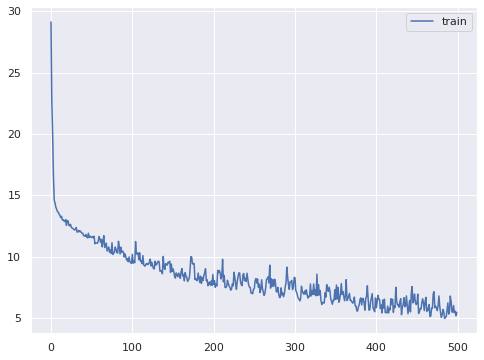

In [72]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(t_x_sacled.shape[1], t_x_sacled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(t_x_sacled, t_y, epochs=500, batch_size=32, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [90]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 32)                5120      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [77]:
predicted = model.predict(t_x_sacled).reshape(-1)
diff = abs(predicted-t_y)
print(np.mean(diff),np.std(diff))

6.334157029148951 12.50544146700553


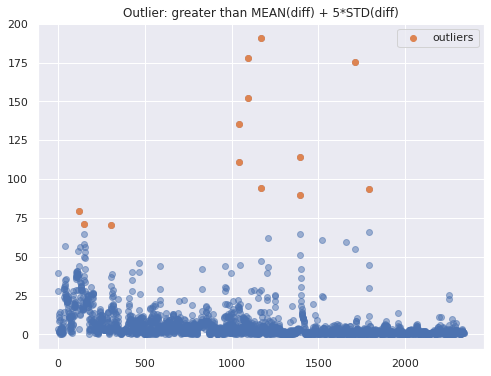

In [141]:
bar = np.mean(diff)+5*np.std(diff)
plt.scatter(range(len(diff)),diff,alpha=0.5)
plt.scatter(np.where(diff>bar), diff[np.where(diff>bar)],label='outliers')
plt.title('Outlier: greater than MEAN(diff) + 5*STD(diff)')
plt.legend()

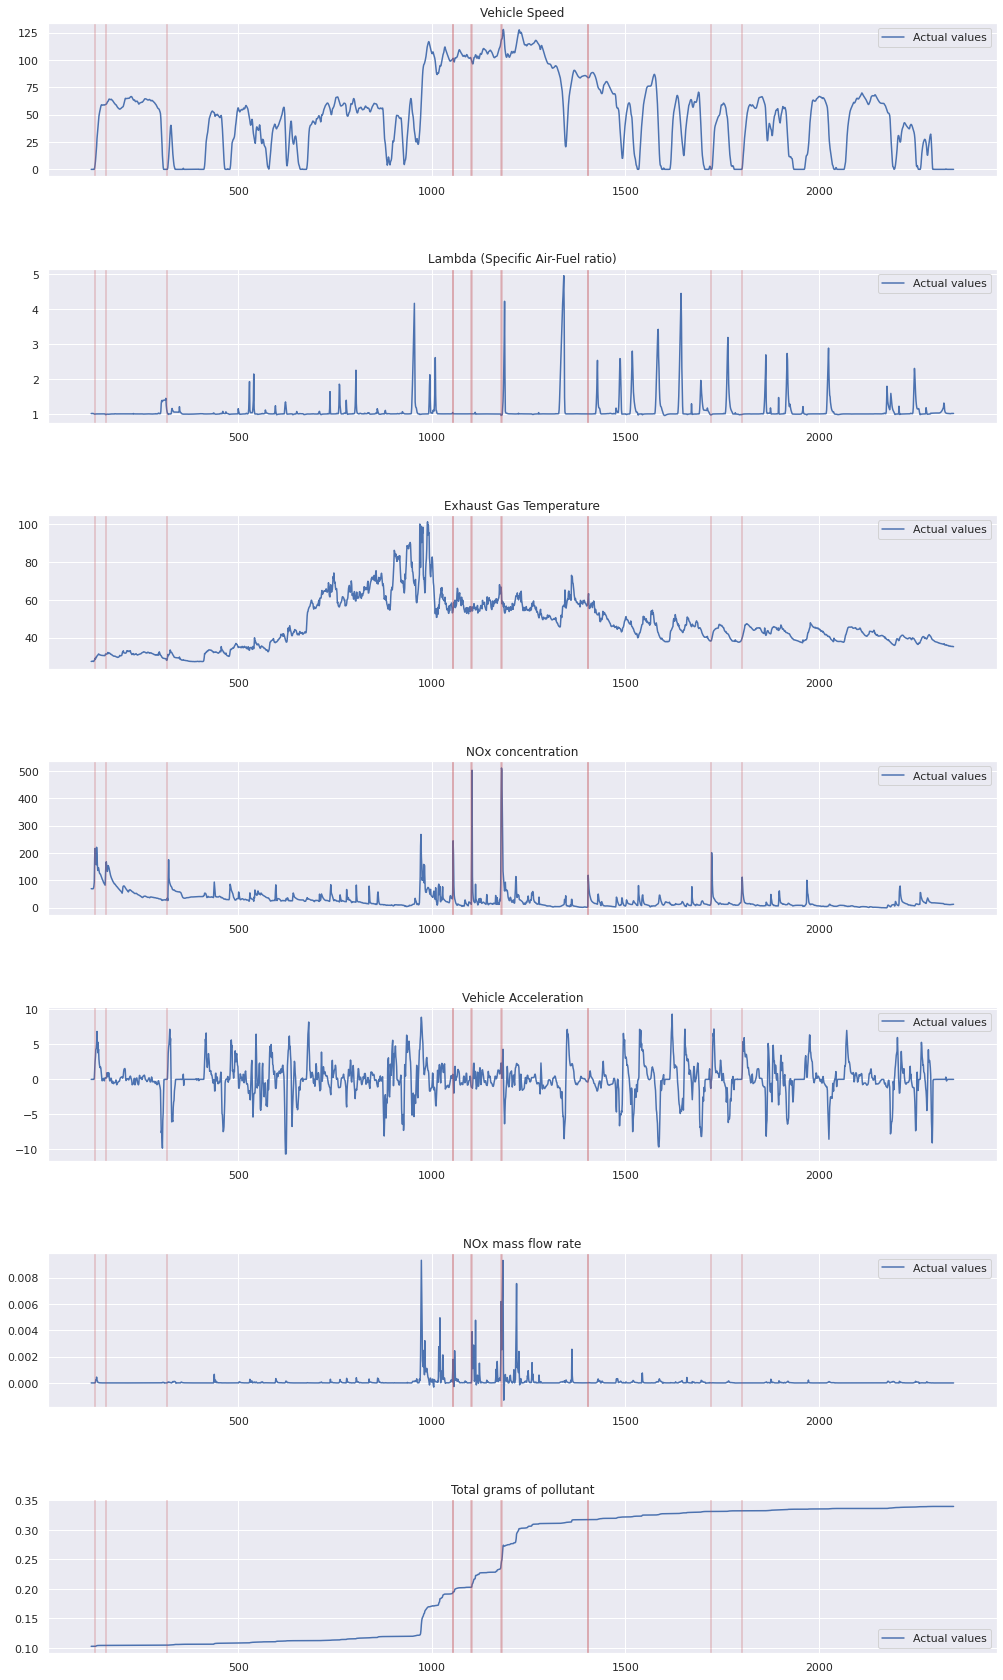

In [142]:
bar = np.mean(diff)+5*np.std(diff)
out_pos = np.where(diff>bar)[0]+10
fig, axes = plt.subplots(7,1,figsize=(17,30))
window=120
for i in range(7):
    rolling_mean = sedan_1.iloc[:,i+1].rolling(window=window).mean()
    ewma = sedan_1.iloc[:,i+1].ewm(span=window,min_periods=window).mean()
#     axes[i].set_title(f'Moving average for {col_name[i]}\n window size = {window}')
#     axes[i].plot(rolling_mean, 'g', label='Rolling mean trend')
    axes[i].plot(sedan_1.iloc[:,i+1][window:], label='Actual values')
#     axes[i].plot(ewma,label='exp')
#     axes[i] = plot_moving_average(sedan_1.iloc[:,i+1],100)
    axes[i].set_title(col_name[i])
    for pos in out_pos:
        axes[i].axvline(pos,color='r',alpha=0.3)
    axes[i].legend()
plt.subplots_adjust(hspace=0.6)

# Autoencoder

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()